In [1]:
import pandas as pd
train_df = pd.read_csv('train.csv')

print(f"{len(train_df)} total entries")
train_df.head()

891 total entries


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
def mean_imputer(raw_array, debug=False):

    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]

    null_count = 0
    sum = 0
    mean = 0
    imputed_array = []

    for item in raw_array:
        if str(item) == 'nan':
            # print(item, end=', ')
            null_count = null_count + 1
        else: sum = sum + item
    
    mean = ( sum / len(raw_array) ) // 1

    if debug == True:
        print(f"\nimputing array --> {namestr(raw_array, globals())[0]}")
        print(f"{null_count} null values")
        print(f"{len(raw_array) - null_count} numeric values")
        print(f"{len(raw_array)} total values")
        print(f"mean = { mean }")
        print(f"replaced all missing values with mean {mean}\n")

    for item in raw_array:
        if str(item) == 'nan':
            item = mean
        imputed_array.append(item)
        # print(item, end=', ')

    return imputed_array

In [3]:
raw_age = list(train_df['Age'])         # missing values
imputed_age = mean_imputer(raw_age, debug=True)


imputing array --> raw_age
177 null values
714 numeric values
891 total values
mean = 23.0
replaced all missing values with mean 23.0



In [4]:
import tensorflow as tf

def categorical(raw_array, tokenizer, debug=False):

    def namestr(obj, namespace):
        return [name for name in namespace if namespace[name] is obj]


    seq_array = tokenizer.texts_to_sequences(raw_array)

    cat_array = tf.keras.utils.to_categorical(seq_array)
    cat_array = cat_array[:, 1:]   # cause the [0] value doesnt have anything in the word index


    if debug == True:
        print(f"\ncategorising array --> {namestr(raw_array, globals())[0]}")
        print(f"unique values --> {tokenizer.word_index}")
        for i in range(5):
            print(f"{raw_array[i]} --> { cat_array[i] }")
        print()
        
    return cat_array
    

In [5]:
raw_sex = list(train_df['Sex'])         # categorical

sex_tokenizer = tf.keras.preprocessing.text.Tokenizer( lower=False )
sex_tokenizer.fit_on_texts(raw_sex)

cat_sex = categorical(raw_sex, sex_tokenizer, debug=True)


categorising array --> raw_sex
unique values --> {'male': 1, 'female': 2}
male --> [1. 0.]
female --> [0. 1.]
female --> [0. 1.]
female --> [0. 1.]
male --> [1. 0.]



In [6]:
def most_common_imputer(array, debug=False):

    most_common = max(array, key = array.count)
    missing_values = 0

    for i in range(len(array)):
        if str( array[i] ) == 'nan':
            missing_values = missing_values + 1
            array[i] = most_common

    if debug == True:
        print(f"missing values --> {missing_values} out of {len(array)}")
        print(f"most common value --> {most_common}")
        print(f"replaced all 'nan' values with '{most_common}'")

    return array

In [7]:
raw_region = list(train_df['Embarked'])     # categorical + missing values
raw_region = most_common_imputer(raw_region, debug=True)

region_tokenizer = tf.keras.preprocessing.text.Tokenizer( lower=False )
region_tokenizer.fit_on_texts(raw_region)

cat_region = categorical(raw_region, region_tokenizer, debug=True)

# for i in range(8):
#     print(f"{raw_region[i]} --> {cat_region[i]}")

missing values --> 2 out of 891
most common value --> S
replaced all 'nan' values with 'S'

categorising array --> raw_region
unique values --> {'S': 1, 'C': 2, 'Q': 3}
S --> [1. 0. 0.]
C --> [0. 1. 0.]
S --> [1. 0. 0.]
S --> [1. 0. 0.]
S --> [1. 0. 0.]



In [8]:
# dropped 'Name', 'Ticket'
# 'Cabin' --> Cabin present or not? 

survived = list(train_df['Survived'])

p_class = list(train_df['Pclass'])

siblings = list(train_df['SibSp'])
parents = list(train_df['Parch'])

fare = list(train_df['Fare'])

print(f"survived --> {list(set(survived))} ")
print(f"passenger class --> {list(set(p_class))} ")
print(f"siblings --> {list(set(siblings))} ")
print(f"parents & children --> {list(set(parents))} ")
print(f"sex --> {list(set(raw_sex))} ")
print(f"region --> {list(set(raw_region))} ")

survived --> [0, 1] 
passenger class --> [1, 2, 3] 
siblings --> [0, 1, 2, 3, 4, 5, 8] 
parents & children --> [0, 1, 2, 3, 4, 5, 6] 
sex --> ['male', 'female'] 
region --> ['Q', 'S', 'C'] 


In [14]:
def binary_categorical(array, debug=False):

    cat_array = []

    for i in range(len(array)):
        if str(array[i]) == 'nan':
            cat_array.append(0)
        else:
            cat_array.append(1)

    if debug == True:
        for i in range(5):
            print(f"{array[i]} --> {cat_array[i]}")
        print(cat_array[:10])

    return cat_array


In [15]:
cabin_present = list(train_df['Cabin'])
cat_cabin = binary_categorical(cabin_present, debug=True)

nan --> 0
C85 --> 1
nan --> 0
C123 --> 1
nan --> 0
[0, 1, 0, 1, 0, 0, 1, 0, 0, 0]


In [16]:
raw_names = list(train_df['Name'])

proc_names = []
positions = ['Mrs.', 'Miss.', 'Rev.', 'Mr.', 'Master.', 'Dr.']

for i in range( len(raw_names) ):
    name_array = raw_names[i].split(' ')
    # print(i, name_array, sep=" --> ")

    token_found = 0
    for token in name_array:
        if token in positions:
            token_found = 1
            # print(f"{token} --> {positions.index(token)}\n")
            # proc_names.append( positions.index(token) )
            proc_names.append( token )
    if token_found == 0:
        proc_names.append( 'Mr.' )

for i in range(len(positions)):
    print(f"{i} --> {positions[i]} --> count = {proc_names.count(positions[i])}")

print(proc_names[:10])


0 --> Mrs. --> count = 125
1 --> Miss. --> count = 182
2 --> Rev. --> count = 6
3 --> Mr. --> count = 531
4 --> Master. --> count = 40
5 --> Dr. --> count = 7
['Mr.', 'Mrs.', 'Miss.', 'Mrs.', 'Mr.', 'Mr.', 'Mr.', 'Master.', 'Mrs.', 'Mrs.']


In [17]:
name_tokenizer = tf.keras.preprocessing.text.Tokenizer( lower=False )
name_tokenizer.fit_on_texts(proc_names)

cat_names = categorical(proc_names, name_tokenizer, debug=True)

print(cat_names[:5])


categorising array --> proc_names
unique values --> {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Dr': 5, 'Rev': 6}
Mr. --> [1. 0. 0. 0. 0. 0.]
Mrs. --> [0. 0. 1. 0. 0. 0.]
Miss. --> [0. 1. 0. 0. 0. 0.]
Mrs. --> [0. 0. 1. 0. 0. 0.]
Mr. --> [1. 0. 0. 0. 0. 0.]

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [18]:
train_x = []

for i in range(len(raw_sex)):
    temp = [
        p_class[i], imputed_age[i],
        siblings[i], parents[i], 
        fare[i], cat_cabin[i]
    ]
    temp.extend(cat_sex[i])
    temp.extend(cat_region[i])
    temp.extend(cat_names[i])
    train_x.append(temp)
    if i < 6: print(temp)  # printing a sample
    

[3, 22.0, 1, 0, 7.25, 0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1, 38.0, 1, 0, 71.2833, 1, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[3, 26.0, 0, 0, 7.925, 0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[1, 35.0, 1, 0, 53.1, 1, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[3, 35.0, 0, 0, 8.05, 0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3, 23.0, 0, 0, 8.4583, 0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [19]:
import numpy as np

survived = list(train_df['Survived'])

train_y = np.array(survived)
train_x = np.array(train_x)

print(train_x.shape)
print("input shape for model =", train_x.shape[1])

(891, 17)
input shape for model = 17


In [20]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

visible = layers.Input( shape=[ train_x.shape[1] ] )
x = layers.Dense(64, activation='relu')(visible)
x = layers.Dropout(0.3)(x)
# x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=visible, outputs=output)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0006,
    patience=40,
    restore_best_weights=False,
)

In [22]:
history = model.fit(
    train_x, train_y,
    validation_split=0.1,
    callbacks=[early_stopping],
    epochs=250,
    verbose=2
)

model.evaluate(train_x, train_y)

Epoch 1/250
26/26 - 2s - loss: 1.9609 - accuracy: 0.5418 - val_loss: 0.7602 - val_accuracy: 0.7222 - 2s/epoch - 77ms/step
Epoch 2/250
26/26 - 0s - loss: 1.5797 - accuracy: 0.5780 - val_loss: 0.7094 - val_accuracy: 0.6556 - 124ms/epoch - 5ms/step
Epoch 3/250
26/26 - 0s - loss: 1.3265 - accuracy: 0.5780 - val_loss: 0.5975 - val_accuracy: 0.6556 - 113ms/epoch - 4ms/step
Epoch 4/250
26/26 - 0s - loss: 1.0784 - accuracy: 0.6192 - val_loss: 0.5922 - val_accuracy: 0.6444 - 158ms/epoch - 6ms/step
Epoch 5/250
26/26 - 0s - loss: 1.1183 - accuracy: 0.5830 - val_loss: 0.5838 - val_accuracy: 0.7000 - 142ms/epoch - 5ms/step
Epoch 6/250
26/26 - 0s - loss: 0.9408 - accuracy: 0.6155 - val_loss: 0.5843 - val_accuracy: 0.6667 - 124ms/epoch - 5ms/step
Epoch 7/250
26/26 - 0s - loss: 0.8054 - accuracy: 0.6417 - val_loss: 0.5918 - val_accuracy: 0.6889 - 129ms/epoch - 5ms/step
Epoch 8/250
26/26 - 0s - loss: 0.7913 - accuracy: 0.6567 - val_loss: 0.5784 - val_accuracy: 0.7111 - 138ms/epoch - 5ms/step
Epoch 9/25

[0.3650702238082886, 0.8529741764068604]

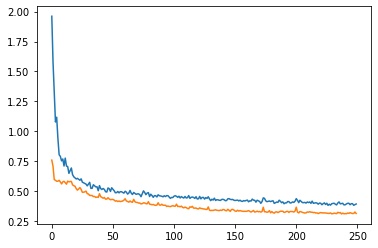

In [23]:
import matplotlib.pyplot as plt

# plt.plot( history.history['accuracy'] )
plt.plot( history.history['loss'] )
plt.plot( history.history['val_loss'] )
plt.show()

In [24]:
# predicting on the testing data

predictions = model.predict(train_x)

correct = 0
for i in range(len(predictions)):
    # print(f"{train_y[i]} predicted --> { (predictions[i][0]*100)//1 } %")

    if predictions[i] > 0.500 and train_y[i] == 1:
            correct = correct + 1

    if predictions[i] < 0.500 and train_y[i] == 0:
            correct = correct + 1

print("predictions on training dataset :-")
print(f"{correct} correct predictions out of {len(predictions)}")
print(f"accuracy = { str((correct / len(predictions)) * 100)[:5] } %")

predictions on training dataset :-
760 correct predictions out of 891
accuracy = 85.29 %


In [25]:
test_df = pd.read_csv('test.csv')

test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [26]:
raw_sex = list(test_df['Sex'])         # categorical

cat_sex = categorical(raw_sex, sex_tokenizer, debug=True)


categorising array --> raw_sex
unique values --> {'male': 1, 'female': 2}
male --> [1. 0.]
female --> [0. 1.]
male --> [1. 0.]
male --> [1. 0.]
female --> [0. 1.]



In [27]:
raw_region = list(test_df['Embarked'])     # categorical + missing values
raw_region = most_common_imputer(raw_region, debug=True)

cat_region = categorical(raw_region, region_tokenizer, debug=True)


missing values --> 0 out of 418
most common value --> S
replaced all 'nan' values with 'S'

categorising array --> raw_region
unique values --> {'S': 1, 'C': 2, 'Q': 3}
Q --> [0. 0. 1.]
S --> [1. 0. 0.]
Q --> [0. 0. 1.]
S --> [1. 0. 0.]
S --> [1. 0. 0.]



In [28]:
# dropped 'Name', 'Ticket'
# 'Cabin' --> Cabin present or not? 

p_class = list(test_df['Pclass'])

siblings = list(test_df['SibSp'])
parents = list(test_df['Parch'])

fare = list(test_df['Fare'])

print(f"passenger class --> {list(set(p_class))} ")
print(f"siblings --> {list(set(siblings))} ")
print(f"parents & children --> {list(set(parents))} ")
print(f"sex --> {list(set(raw_sex))} ")
print(f"region --> {list(set(raw_region))} ")

passenger class --> [1, 2, 3] 
siblings --> [0, 1, 2, 3, 4, 5, 8] 
parents & children --> [0, 1, 2, 3, 4, 5, 6, 9] 
sex --> ['male', 'female'] 
region --> ['S', 'C', 'Q'] 


In [29]:
cabin_present = list(test_df['Cabin'])
cat_cabin = binary_categorical(cabin_present, debug=True)

nan --> 0
nan --> 0
nan --> 0
nan --> 0
nan --> 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [30]:
raw_names = list(test_df['Name'])

proc_names = []
positions = ['Mrs.', 'Miss.', 'Rev.', 'Mr.', 'Master.', 'Dr.']

for i in range( len(raw_names) ):
    name_array = raw_names[i].split(' ')
    # print(i, name_array, sep=" --> ")

    token_found = 0
    for token in name_array:
        if token in positions:
            token_found = 1
            # print(f"{token} --> {positions.index(token)}\n")
            # proc_names.append( positions.index(token) )
            proc_names.append( token )
    if token_found == 0:
        proc_names.append( 'Mr.' )

for i in range(len(positions)):
    print(f"{i} --> {positions[i]} --> count = {proc_names.count(positions[i])}")

print(proc_names[:10])


0 --> Mrs. --> count = 72
1 --> Miss. --> count = 78
2 --> Rev. --> count = 2
3 --> Mr. --> count = 244
4 --> Master. --> count = 21
5 --> Dr. --> count = 1
['Mr.', 'Mrs.', 'Mr.', 'Mr.', 'Mrs.', 'Mr.', 'Miss.', 'Mr.', 'Mrs.', 'Mr.']


In [31]:
cat_names = categorical(proc_names, name_tokenizer, debug=True)

print(cat_names[:5])


categorising array --> proc_names
unique values --> {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Dr': 5, 'Rev': 6}
Mr. --> [1. 0. 0. 0. 0. 0.]
Mrs. --> [0. 0. 1. 0. 0. 0.]
Mr. --> [1. 0. 0. 0. 0. 0.]
Mr. --> [1. 0. 0. 0. 0. 0.]
Mrs. --> [0. 0. 1. 0. 0. 0.]

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [32]:
test_x = []

for i in range(len(raw_sex)):
    temp = [
        p_class[i], imputed_age[i],
        siblings[i], parents[i], 
        fare[i], cat_cabin[i]
    ]
    temp.extend(cat_sex[i])
    temp.extend(cat_region[i])
    temp.extend(cat_names[i])
    test_x.append(temp)
    if i < 6: print(temp)
    
test_x = np.array(test_x)

[3, 22.0, 0, 0, 7.8292, 0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3, 38.0, 1, 0, 7.0, 0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[2, 26.0, 0, 0, 9.6875, 0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3, 35.0, 0, 0, 8.6625, 0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3, 35.0, 1, 1, 12.2875, 0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[3, 23.0, 0, 0, 9.225, 0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [33]:
print(train_x.shape)
print("input shape for test_x =", train_x.shape[1])

(891, 17)
input shape for test_x = 17


In [34]:
predictions = model.predict(test_x)

csv_pred = []
for i in range(len(predictions)):
    if predictions[i][0] > 0.500: 
        csv_pred.append(1)
    else:
        csv_pred.append(0)

print(csv_pred[:50])

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1]


In [35]:
passenger_id = list(test_df['PassengerId'])

submit_dict = {
    'PassengerId': passenger_id,
    'Survived': csv_pred
}

submit_df = pd.DataFrame(submit_dict)
submit_df.head()

submit_df.to_csv('submit.csv')